### Dataset

In [2]:
# importing needed libraries
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

Creating dataframe from d.csv. Because we will create a lot of "subdataframes" let's name it df_full.

In [3]:
df_full = pd.read_csv("d.csv")

Let's display some important info about our dataset to get familiar with it.

In [4]:
display(df_full.info())
print("----------------------")
display(df_full.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642433 entries, 0 to 1642432
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   stop_from       1642433 non-null  object
 1   stop_from_name  1642433 non-null  object
 2   stop_to         1642433 non-null  object
 3   stop_to_name    1642433 non-null  object
 4   depart_from     1642433 non-null  object
 5   arrive_to       1642433 non-null  object
 6   route_type      1642433 non-null  int64 
 7   is_night        1642433 non-null  int64 
 8   monday          1642433 non-null  int64 
 9   tuesday         1642433 non-null  int64 
 10  wednesday       1642433 non-null  int64 
 11  thursday        1642433 non-null  int64 
 12  friday          1642433 non-null  int64 
 13  saturday        1642433 non-null  int64 
 14  sunday          1642433 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 188.0+ MB


None

----------------------


stop_from      stop_from_name    stop_to        stop_to_name depart_from  \
0  U2991Z301             Hněvice     T58005      Hněvice seř.n.     4:53:00   
1     T58005      Hněvice seř.n.  U4610Z301              Záluží     4:54:30   
2  U4610Z301              Záluží  U4609Z301              Dobříň     4:56:00   
3  U4609Z301              Dobříň  U4608Z301  Roudnice nad Labem     4:59:00   
4  U4608Z301  Roudnice nad Labem  U4609Z301              Dobříň     4:36:00   
5  U4609Z301              Dobříň  U4610Z301              Záluží     4:38:00   
6  U4610Z301              Záluží     T58005      Hněvice seř.n.     4:39:00   
7     T58005      Hněvice seř.n.  U2991Z301             Hněvice     4:40:30   
8  U2991Z301             Hněvice     T58005      Hněvice seř.n.     5:53:00   
9     T58005      Hněvice seř.n.  U4610Z301              Záluží     5:54:30   

  arrive_to  route_type  is_night  monday  tuesday  wednesday  thursday  \
0   4:54:30           2         0       1        1          1         1   
1   4:56:00           2         0       1        1          1         1   
2   4:59:00           2         0       1        1          1         1   
3   5:03:00           2         0       1        1          1         1   
4   4:38:00           2         0       1        1          1         1   
5   4:39:00           2         0       1        1          1         1   
6   4:40:30           2         0       1        1          1         1   
7   4:41:30           2         0       1        1          1         1   
8   5:54:30           2         0       1        1          1         1   
9   5:56:00           2         0       1        1          1         1   

   friday  saturday  sunday  
0       1         0       0  
1       1         0       0  
2       1         0       0  
3       1         0       0  
4       1         0       0  
5       1         0       0  
6       1         0       0  
7       1         0       0  
8       1         1       1  
9       1         1       1

### Data Preprocessing

There is no missing values in our dataset. Most of the features are either objects or int64, which is totally fine for our future work. 

It would be more convenient for us in the future to change the data type of features `depart_from` and `arrive_to` from object to datetime64. Due to special format GTFS the time could be a value greater than 24:00:00. Let's write a function, which would deal with that and then change dtype of these columns. (There is only one thing, datetime64 can't store only time without date, so it will automatically after changing the type write 1900-01-01 to our column, which is not true, but it will not bother us in the future)

In [5]:
# module of hours by 24
def hours_mod_24(cell):
    time_parts = cell.split(':')
    time_parts[0] = int(time_parts[0])
    time_parts[0] = time_parts[0] % 24
    return str(time_parts[0]) + ':' + time_parts[1] + ':' + time_parts[2]

# applying function
df_full['depart_from'] = df_full['depart_from'].apply(hours_mod_24)
df_full['arrive_to'] = df_full['arrive_to'].apply(hours_mod_24)

# changing type
df_full['depart_from'] = pd.to_datetime(df_full['depart_from'], format='%H:%M:%S')
df_full['arrive_to'] = pd.to_datetime(df_full['arrive_to'], format='%H:%M:%S')

Our dataset after short preprocessing.

In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642433 entries, 0 to 1642432
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   stop_from       1642433 non-null  object        
 1   stop_from_name  1642433 non-null  object        
 2   stop_to         1642433 non-null  object        
 3   stop_to_name    1642433 non-null  object        
 4   depart_from     1642433 non-null  datetime64[ns]
 5   arrive_to       1642433 non-null  datetime64[ns]
 6   route_type      1642433 non-null  int64         
 7   is_night        1642433 non-null  int64         
 8   monday          1642433 non-null  int64         
 9   tuesday         1642433 non-null  int64         
 10  wednesday       1642433 non-null  int64         
 11  thursday        1642433 non-null  int64         
 12  friday          1642433 non-null  int64         
 13  saturday        1642433 non-null  int64         
 14  sunday          16

### Basic Network Analysis

We will use NetworkX library, which we have explored on tutorials. First of all, let's create a directed graph of our transportation network. Because the whole network is extremely large for our visualisation and statistics, let's filter tram stops and its connections.

In [7]:
# filter tram records (0 - tram route)
df_tram = df_full[df_full['route_type'] == 0]

In [8]:
# creating directed graph
tram_net = nx.DiGraph()
# iterate through rows
for _, row in df_tram.iterrows():
    # adding nodes
    tram_net.add_node(row['stop_from_name'])
    tram_net.add_node(row['stop_to_name'])
    # adding edge
    tram_net.add_edge(row['stop_from_name'], row['stop_to_name'])

In [9]:
print("Number of tram stops - ", len(tram_net.nodes))
print("Number of edges in tram_net - ", len(tram_net.edges))

Number of tram stops -  281
Number of edges in tram_net -  661


The visualisation looks like a mess, let's attach to stops their coordinates from stops.txt file and make some additional changes to enhance it.

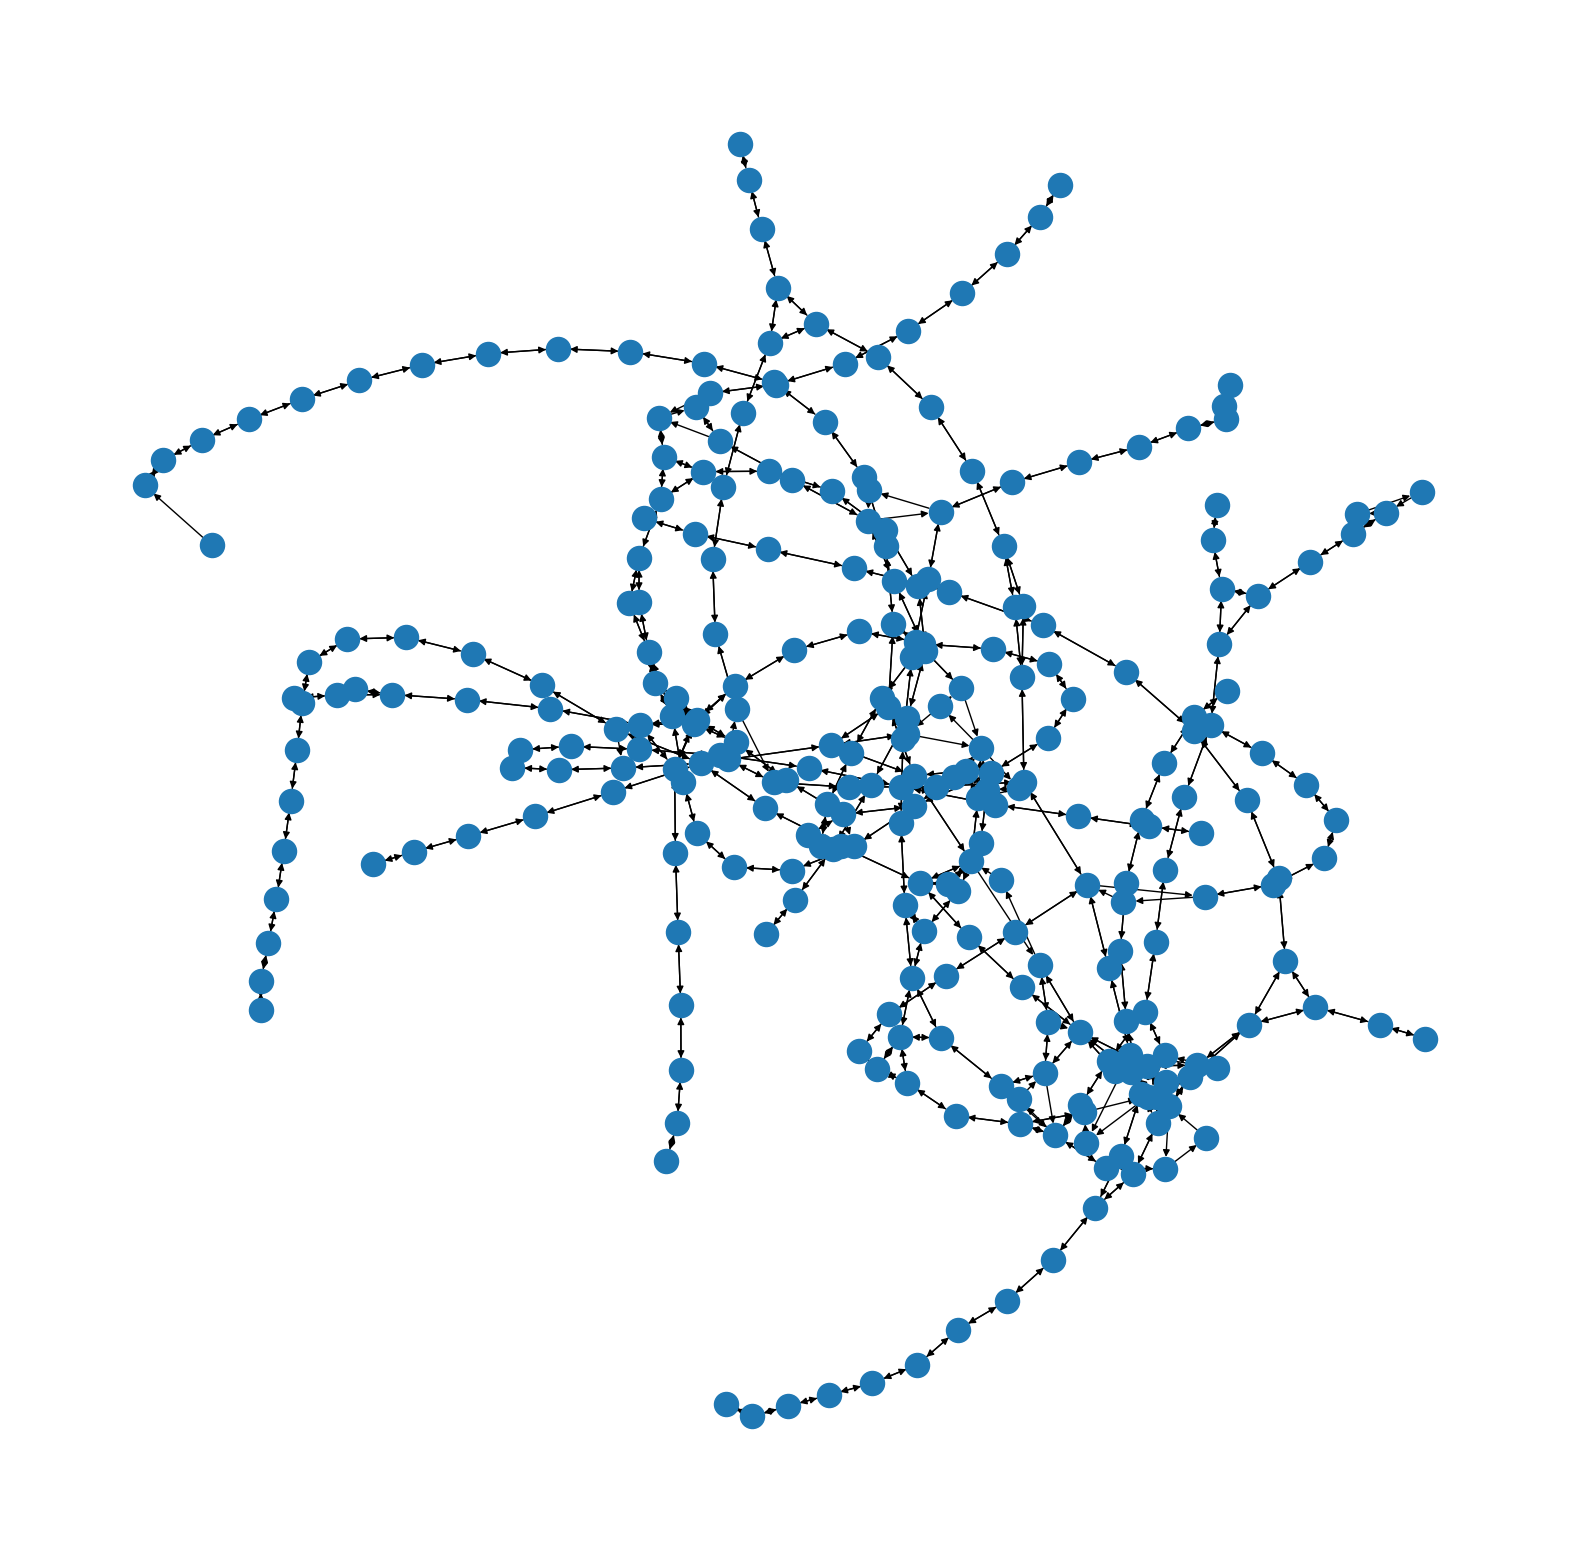

In [10]:
fig, ax = plt.subplots(figsize=(20, 20))
nx.draw(tram_net, with_labels=False)

In [11]:
# create dataset
df_stops = pd.read_csv("stops.txt")

Some basic info about df_stops to get familiar with it.

In [12]:
display(df_stops.info())
print("--------------")
display(df_stops.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16435 entries, 0 to 16434
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   stop_id              16435 non-null  object 
 1   stop_name            15936 non-null  object 
 2   stop_lat             16435 non-null  float64
 3   stop_lon             16435 non-null  float64
 4   zone_id              15408 non-null  object 
 5   stop_url             0 non-null      float64
 6   location_type        16435 non-null  int64  
 7   parent_station       954 non-null    object 
 8   wheelchair_boarding  16435 non-null  int64  
 9   level_id             954 non-null    object 
 10  platform_code        14750 non-null  object 
 11  asw_node_id          15748 non-null  float64
 12  asw_stop_id          15354 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 1.6+ MB


None

--------------


stop_id    stop_name   stop_lat   stop_lon zone_id  stop_url  location_type  \
0   U50S1  Budějovická  50.044411  14.448787       P       NaN              1   
1   U52S1       Chodov  50.031672  14.490961       P       NaN              1   
2   U75S1    Kolbenova  50.110395  14.516398       P       NaN              1   
3   U78S1        Ládví  50.126591  14.469451       P       NaN              1   
4  U100S1     Vltavská  50.100298  14.438492       P       NaN              1   

  parent_station  wheelchair_boarding level_id platform_code  asw_node_id  \
0            NaN                    1      NaN           NaN         50.0   
1            NaN                    1      NaN           NaN         52.0   
2            NaN                    1      NaN           NaN         75.0   
3            NaN                    1      NaN           NaN         78.0   
4            NaN                    1      NaN           NaN        100.0   

   asw_stop_id  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

Most of the stops in Prague with the same name have almost identical coordinates, for our purposes is enough of precision to take just the first one. 

In [13]:
# coordinates of nodes (names of tram stops)
tram_stop_pos = {}
# coordinates of labels of nodes
tram_stop_names_pos = {}
# indicator to switch position of labels (up or down), it will enhance the looking of our visualisation 
indicator = True

# go through all tram stops
for tram_stop in tram_net.nodes:
    needed_stop = df_stops[(df_stops['stop_name'] == tram_stop)]
    tram_stop_pos[tram_stop] = np.array([needed_stop['stop_lat'].iloc[0], needed_stop['stop_lon'].iloc[0]][::-1])
    
    # adding some constants to coordinates of labels for better looking
    if indicator:
        tram_stop_names_pos[tram_stop] = np.array([needed_stop['stop_lat'].iloc[0] + 0.001, needed_stop['stop_lon'].iloc[0] + 0.001][::-1])
    else:
        tram_stop_names_pos[tram_stop] = np.array([needed_stop['stop_lat'].iloc[0] - 0.0025, needed_stop['stop_lon'].iloc[0] + 0.001][::-1])
    # switch
    indicator = not indicator

We have everything we need for better looking visualisation of our graph.  

It would be disturbing to have orientation on every edge, so let's remove it with parameter 'arrows' in nx.draw_networkx_edges. (By the way, it looks like all edges are both oriented, so there is even no need for them)  

Size of labels can look small, but with increasing it starts to intersect more often, especially in the center, which looks bad. (On big screen, it looks quite nice)

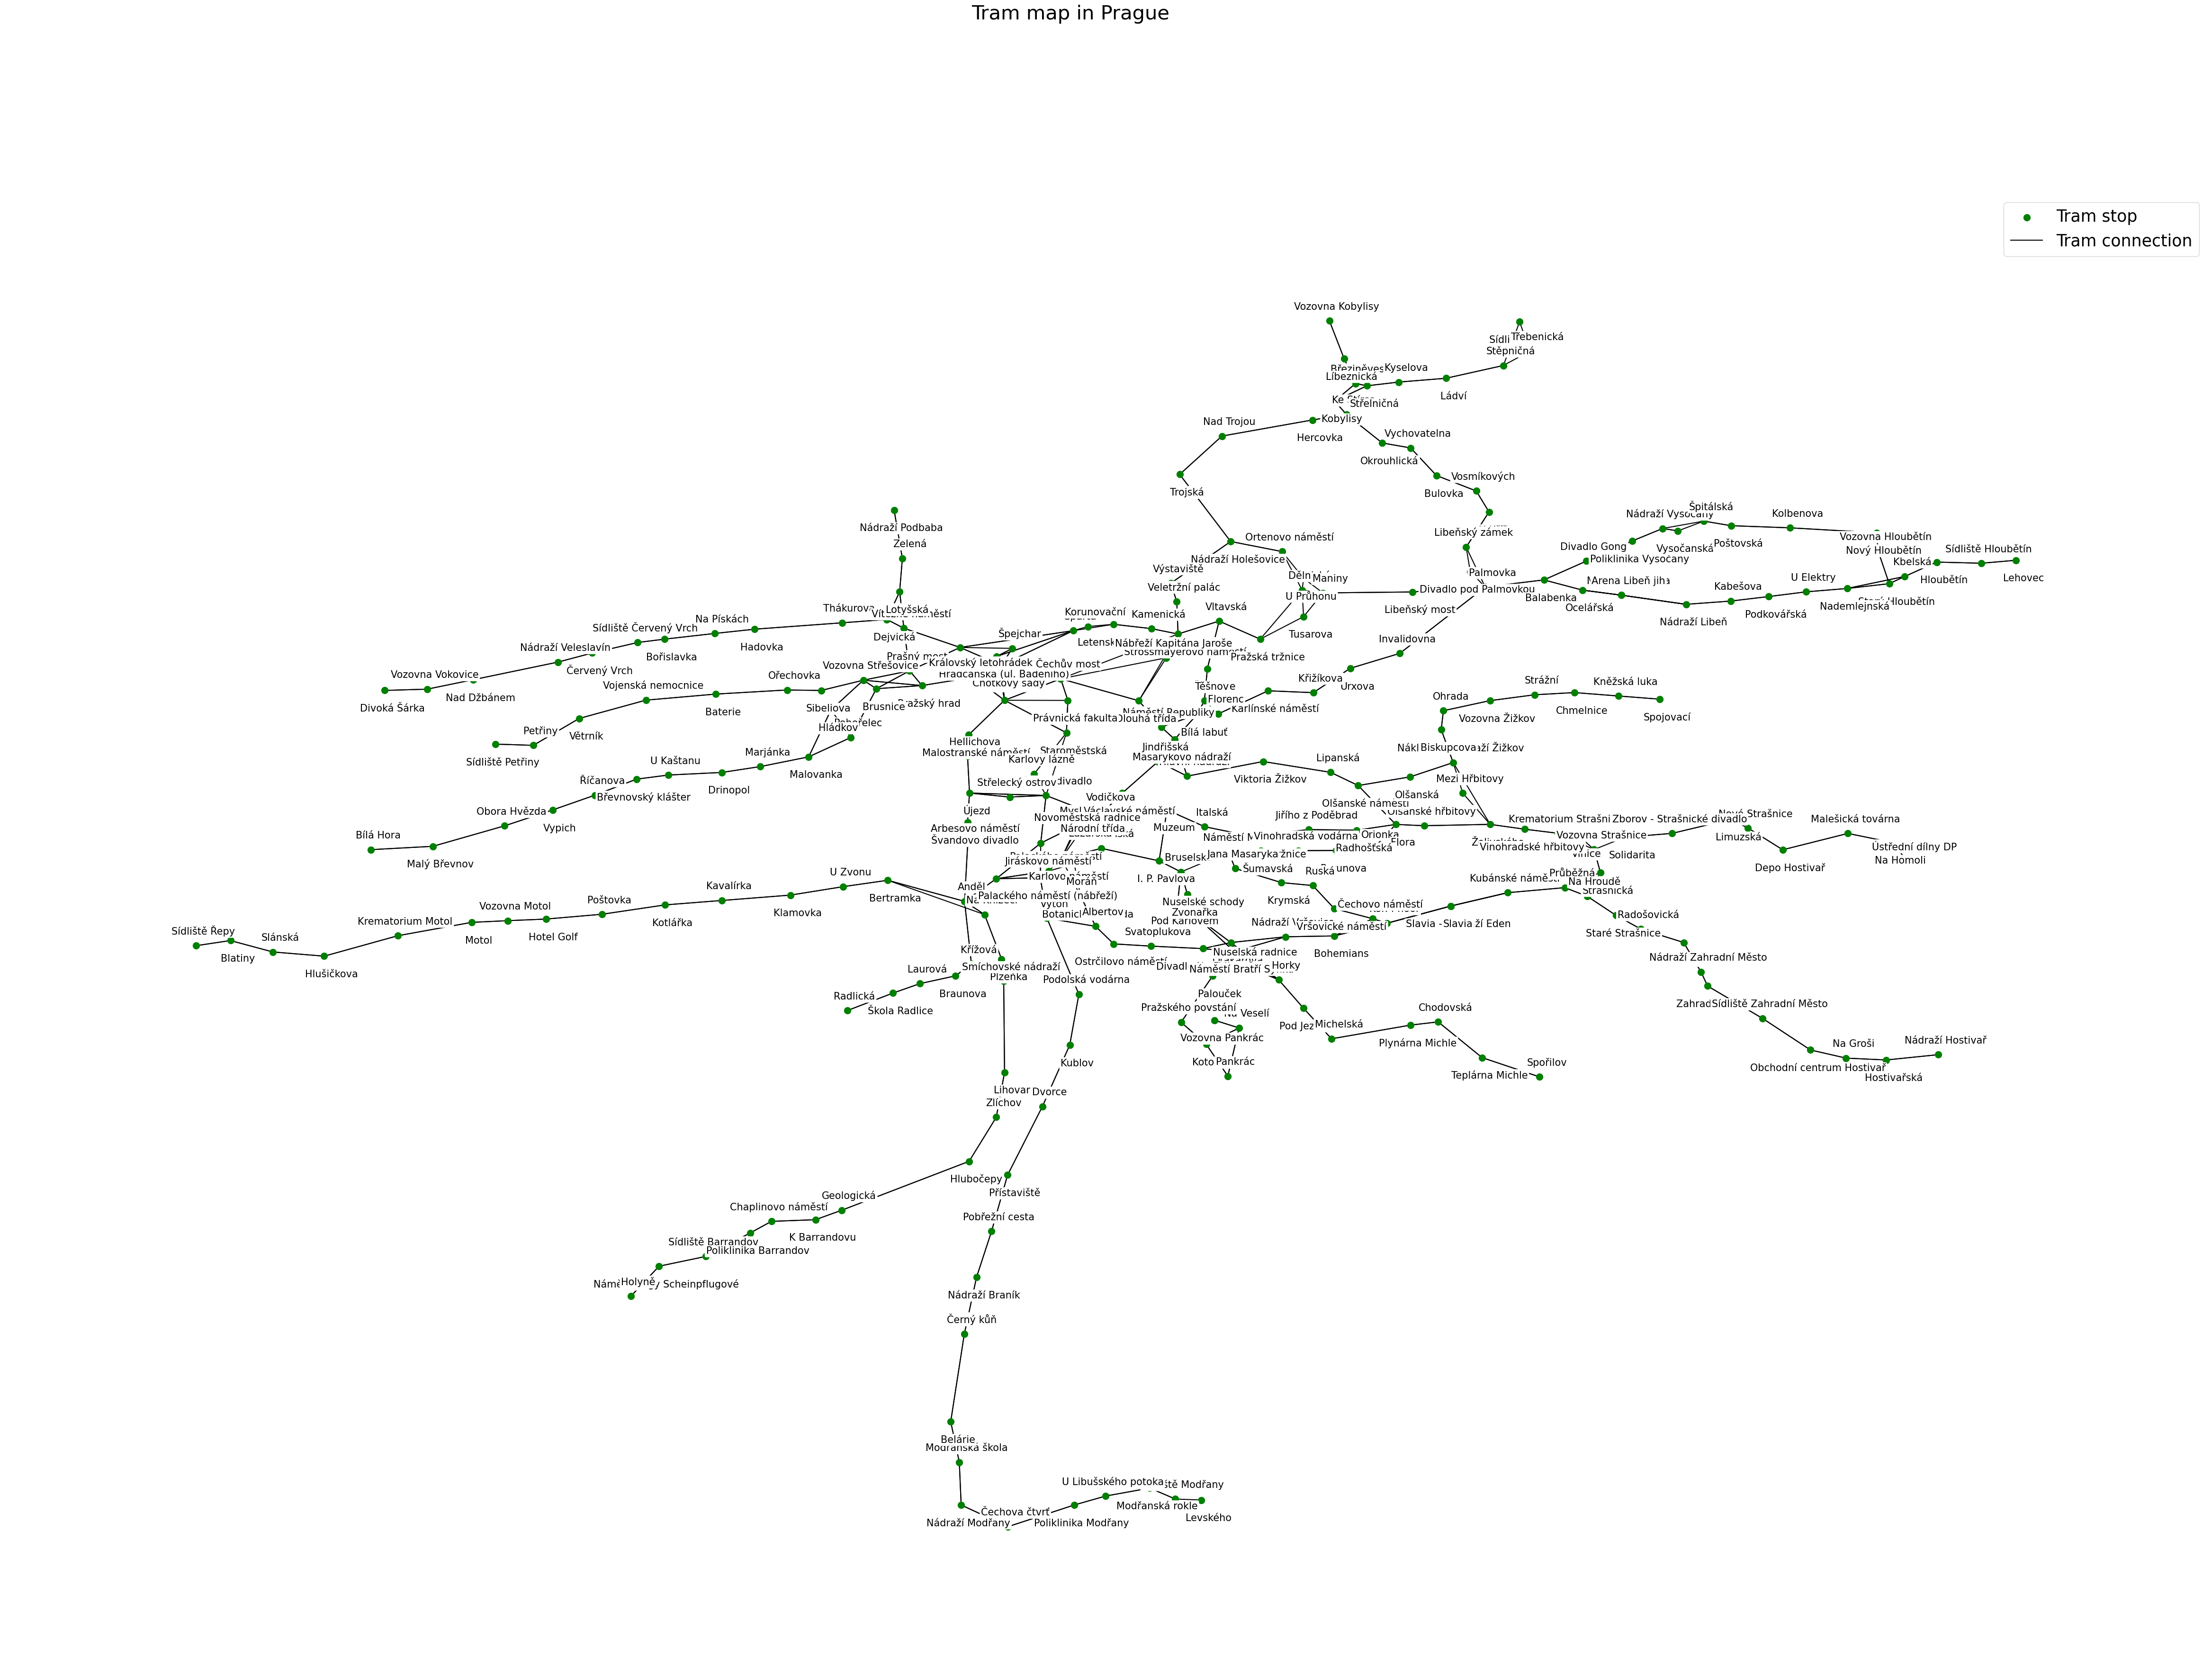

In [14]:
fig, ax = plt.subplots(figsize=(60, 40))

# drawing nodes
nx.draw_networkx_nodes(
    tram_net,
    tram_stop_pos,
    node_color = "green",
    label = "Tram stop",
    node_size = 100,
)

# drawing edges
nx.draw_networkx_edges(
    tram_net,
    tram_stop_pos,
    width = 1.5,
    style="solid",
    label="Tram connection",
    arrows=False
)

# names of stops
nx.draw_networkx_labels(
    tram_net,
    tram_stop_names_pos,
    font_size = 15,
    horizontalalignment = "center",
    verticalalignment = "bottom",
    bbox=dict(boxstyle="round,pad=0.1", edgecolor="white", facecolor="white")
)

plt.legend(fontsize='25')

fig.suptitle("Tram map in Prague", size=30)
plt.axis("off")

plt.show()

For calculating centralities we will use built-in methods of networkX. Because we need to calculate for a whole week, and also we need to take into account that in dataset we have the same connections for different time, which we have not added previously because it was just directed graph, let's create directed multi graph to add edges for every day and every record according to our dataset. (We could add weights to directed graph without creating new multi one, but this solution looks more simple from my perspective)

In [15]:
tram_net_multi = nx.MultiDiGraph()

In [16]:
for _, row in df_tram.iterrows():
    row_list = row.to_list()
    days_of_weeks = row_list[-7:]
    
    tram_net_multi.add_node(row['stop_from_name'])
    tram_net_multi.add_node(row['stop_to_name'])
    
    # adding edge for every day, which is True in dataset
    for day in days_of_weeks:
        if day:
            tram_net_multi.add_edge(row['stop_from_name'], row['stop_to_name'])

In [17]:
print("Number of tram stops - ", len(tram_net_multi.nodes))
print("Number of edges in tram_net_multi - ", len(tram_net_multi.edges))

Number of tram stops -  281
Number of edges in tram_net_multi -  2387039


In transportation networks, degree centrality of tram stop represents the number of direct routes passing through a particular stop (its degree).  

Tram stop with high degree centrality is one that serves as a major hub, connecting to many other stops directly. It indicates that the stop is crucial for the overall connectivity of the transportation network.   

Below we can see top 10 stops with the highest degree centrality.

In [18]:
degree_centrality = nx.degree_centrality(tram_net_multi)
# sort trams stops by its degree centrality
degree_centrality_sorted = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
# top 10
degree_centrality_sorted[0:10]

[('Karlovo náměstí', 197.27142857142857),
 ('Anděl', 179.55714285714285),
 ('Národní divadlo', 173.92857142857142),
 ('Strossmayerovo náměstí', 160.8357142857143),
 ('Národní třída', 150.06428571428572),
 ('I. P. Pavlova', 146.75),
 ('Malostranská', 145.62142857142857),
 ('Nákladové nádraží Žižkov', 138.27142857142857),
 ('Újezd', 136.7642857142857),
 ('Palmovka', 130.47857142857143)]

Betweenness centrality quantifies the number of times node acts as a bridge along the shortest path between two other nodes. It identifies nodes that control the flow of traffic through the network.  

A tram stop with high betweenness centrality acts as a crucial link between different parts of the network. It is likely to be on paths that many travelers take, making it strategically important for the overall efficiency of the whole tram system.  

Below we can see top 10 tram stops with the highest betweenness centrality. (It is important to notice, that this top differs from the previous one)

In [19]:
betweenness_centrality = nx.betweenness_centrality(tram_net_multi)
# sort trams stops by its degree centrality
betweenness_centrality_sorted = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
# top 10
betweenness_centrality_sorted[0:10]

[('Malostranská', 0.3411205249670113),
 ('Národní divadlo', 0.2809070798846151),
 ('Čechův most', 0.2709754949991128),
 ('Staroměstská', 0.2669918994429367),
 ('Strossmayerovo náměstí', 0.2507858151761762),
 ('Jiráskovo náměstí', 0.2419822123316749),
 ('Anděl', 0.2120394752883232),
 ('Výtoň', 0.21180282815267482),
 ('Masarykovo nádraží', 0.19318814601936793),
 ('Zborovská', 0.19146014678272746)]

Closeness centrality measures how close node is to all other nodes in the network. It is calculated as the inverse of the sum of the shortest path distances from a node to all other nodes.  

It suggests that tram stop with high closeness centrality is well-connected and can be reached quickly from other stops, making it potentially important for efficient travel within the network.  

The top is also different from two previous.

In [20]:
closeness_centrality = nx.closeness_centrality(tram_net_multi)
# sort trams stops by its closeness centrality
closeness_centrality_sorted = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
# top 10
closeness_centrality_sorted[0:10]

[('Malostranská', 0.09625300790649707),
 ('Staroměstská', 0.09543285616905249),
 ('Čechův most', 0.09488309047780413),
 ('Strossmayerovo náměstí', 0.0937395379979913),
 ('Právnická fakulta', 0.09317803660565724),
 ('Karlovo náměstí', 0.09293063391968139),
 ('Národní divadlo', 0.09201445941505093),
 ('Dlouhá třída', 0.09186351706036745),
 ('Jiráskovo náměstí', 0.09070294784580499),
 ('Masarykovo nádraží', 0.0901481004507405)]

Let's visualise the last centrality.  

In visualisation of closeness centrality it looks better when nodes with high values are lighter than nodes with low values (especially in dark mode) from my perspective.

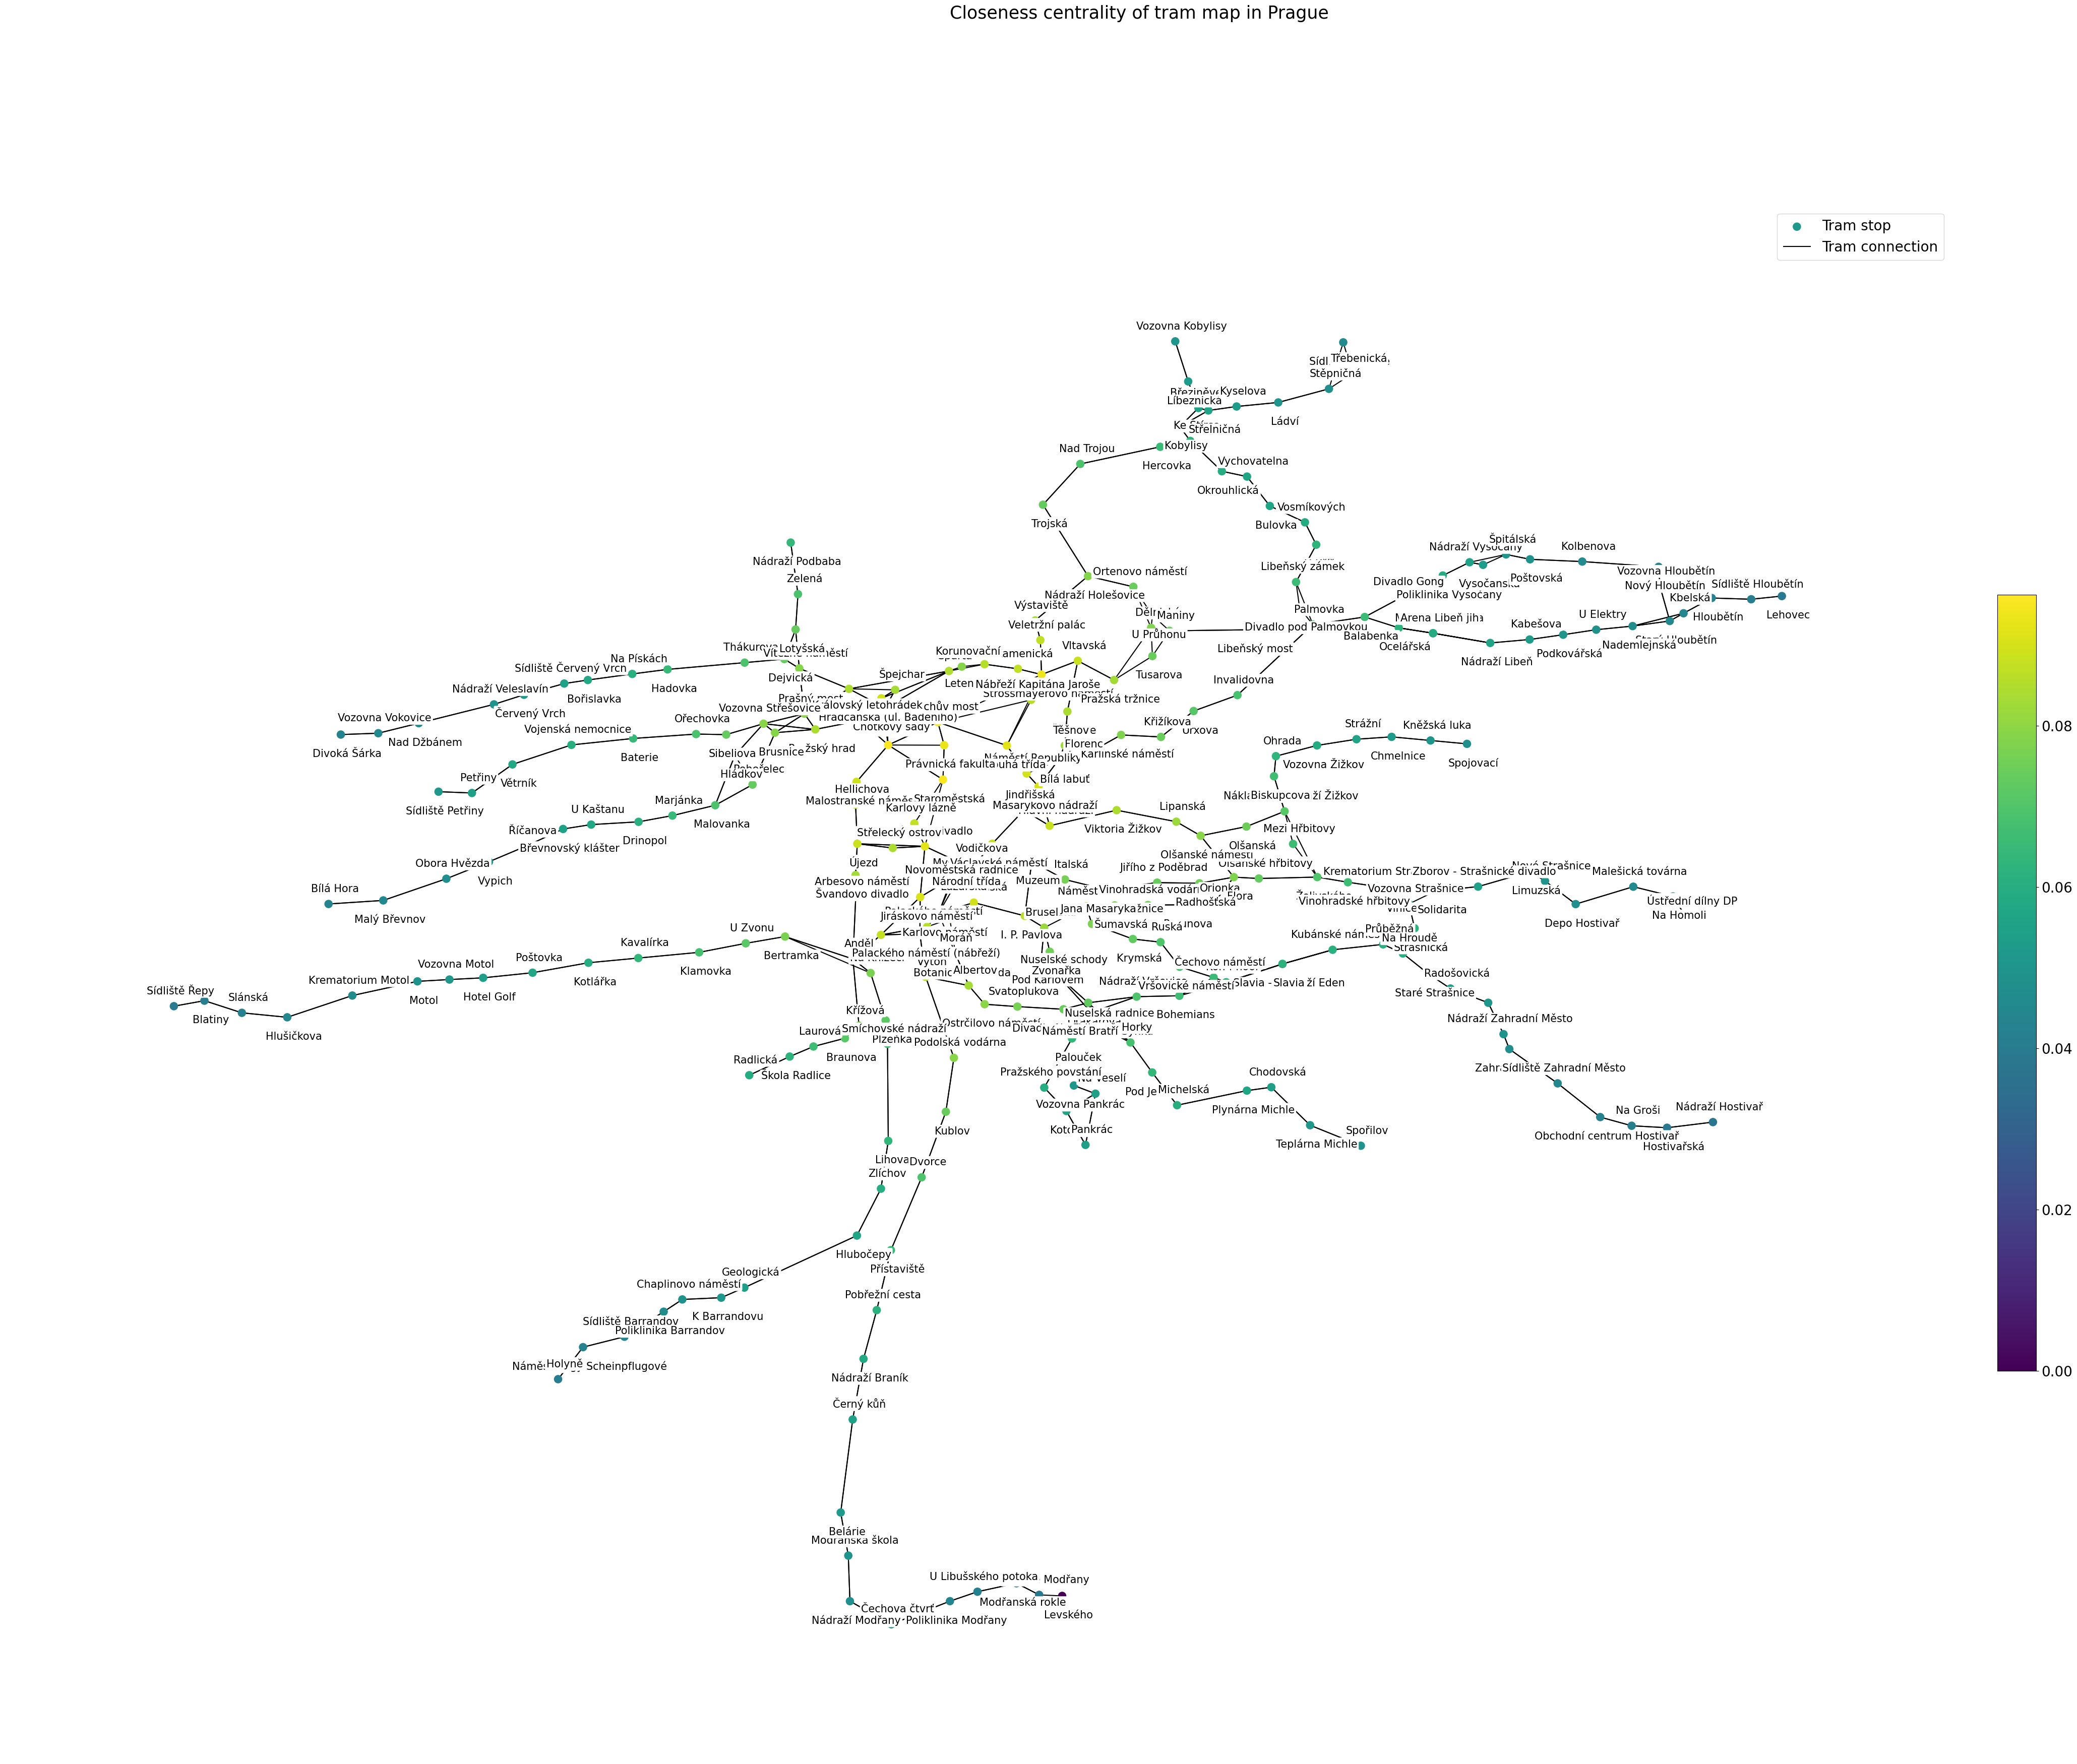

In [21]:
fig, ax = plt.subplots(figsize=(60, 40))

node_colors = [closeness_centrality[node] for node in tram_net.nodes]

# drawing nodes
nx.draw_networkx_nodes(
    tram_net,
    tram_stop_pos,
    node_color=node_colors,
    # setting up color map
    cmap=plt.cm.viridis,
    label = "Tram stop",
    node_size = 120,
)

# drawing edges
nx.draw_networkx_edges(
    tram_net,
    tram_stop_pos,
    width = 1.5,
    style="solid",
    label="Tram connection",
    arrows=False
)

# names of stops
nx.draw_networkx_labels(
    tram_net,
    tram_stop_names_pos,
    font_size = 15,
    horizontalalignment = "center",
    verticalalignment = "bottom",
    bbox=dict(boxstyle="round,pad=0.1", edgecolor="white", facecolor="white")
)

# adding color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
cbar = plt.colorbar(sm, orientation='vertical', shrink=0.5, pad=0.02, ax=ax)
cbar.ax.tick_params(labelsize=20)

plt.legend(fontsize='20')

fig.suptitle("Closeness centrality of tram map in Prague", size=25)
plt.axis("off")

plt.show()

### Own questions

1. What are important tram stops in terms of closeness centrality at night? Visualise centrality.

In [22]:
# filter night rotes
df_tram_night = df_tram[df_tram["is_night"] == 1]

In [23]:
tram_net_night_multi = nx.MultiDiGraph()
for _, row in df_tram_night.iterrows():
    row_list = row.to_list()
    days_of_weeks = row_list[-7:]
    
    tram_net_night_multi.add_node(row['stop_from_name'])
    tram_net_night_multi.add_node(row['stop_to_name'])
    
    # adding edge for every day, which is True in dataset
    for day in days_of_weeks:
        if day:
            tram_net_night_multi.add_edge(row['stop_from_name'], row['stop_to_name'])

In [24]:
print("Number of tram stops - ", len(tram_net_night_multi.nodes))
print("Number of edges in tram_net_night_multi - ", len(tram_net_night_multi.edges))

Number of tram stops -  259
Number of edges in tram_net_night_multi -  102619


From our top nodes with the highest closeness centrality at night we can see that on the first place is tram stop 'Lazarská', which is not even in top ten of the tram stops for a whole day and a whole week.  
  
It means that 'Lazarská' is really important for efficient travel within the network at night time.

In [25]:
closeness_centrality = nx.degree_centrality(tram_net_night_multi)
# sort trams stops by its closeness centrality
closeness_centrality_sorted = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
# top 10
closeness_centrality_sorted[0:10]

[('Lazarská', 17.852713178294575),
 ('Karlovo náměstí', 15.604651162790697),
 ('Vodičkova', 11.193798449612403),
 ('Václavské náměstí', 11.193798449612403),
 ('Jindřišská', 11.193798449612403),
 ('Národní třída', 8.96124031007752),
 ('Národní divadlo', 8.96124031007752),
 ('I. P. Pavlova', 8.689922480620154),
 ('Štěpánská', 8.635658914728682),
 ('Novoměstská radnice', 7.782945736434108)]

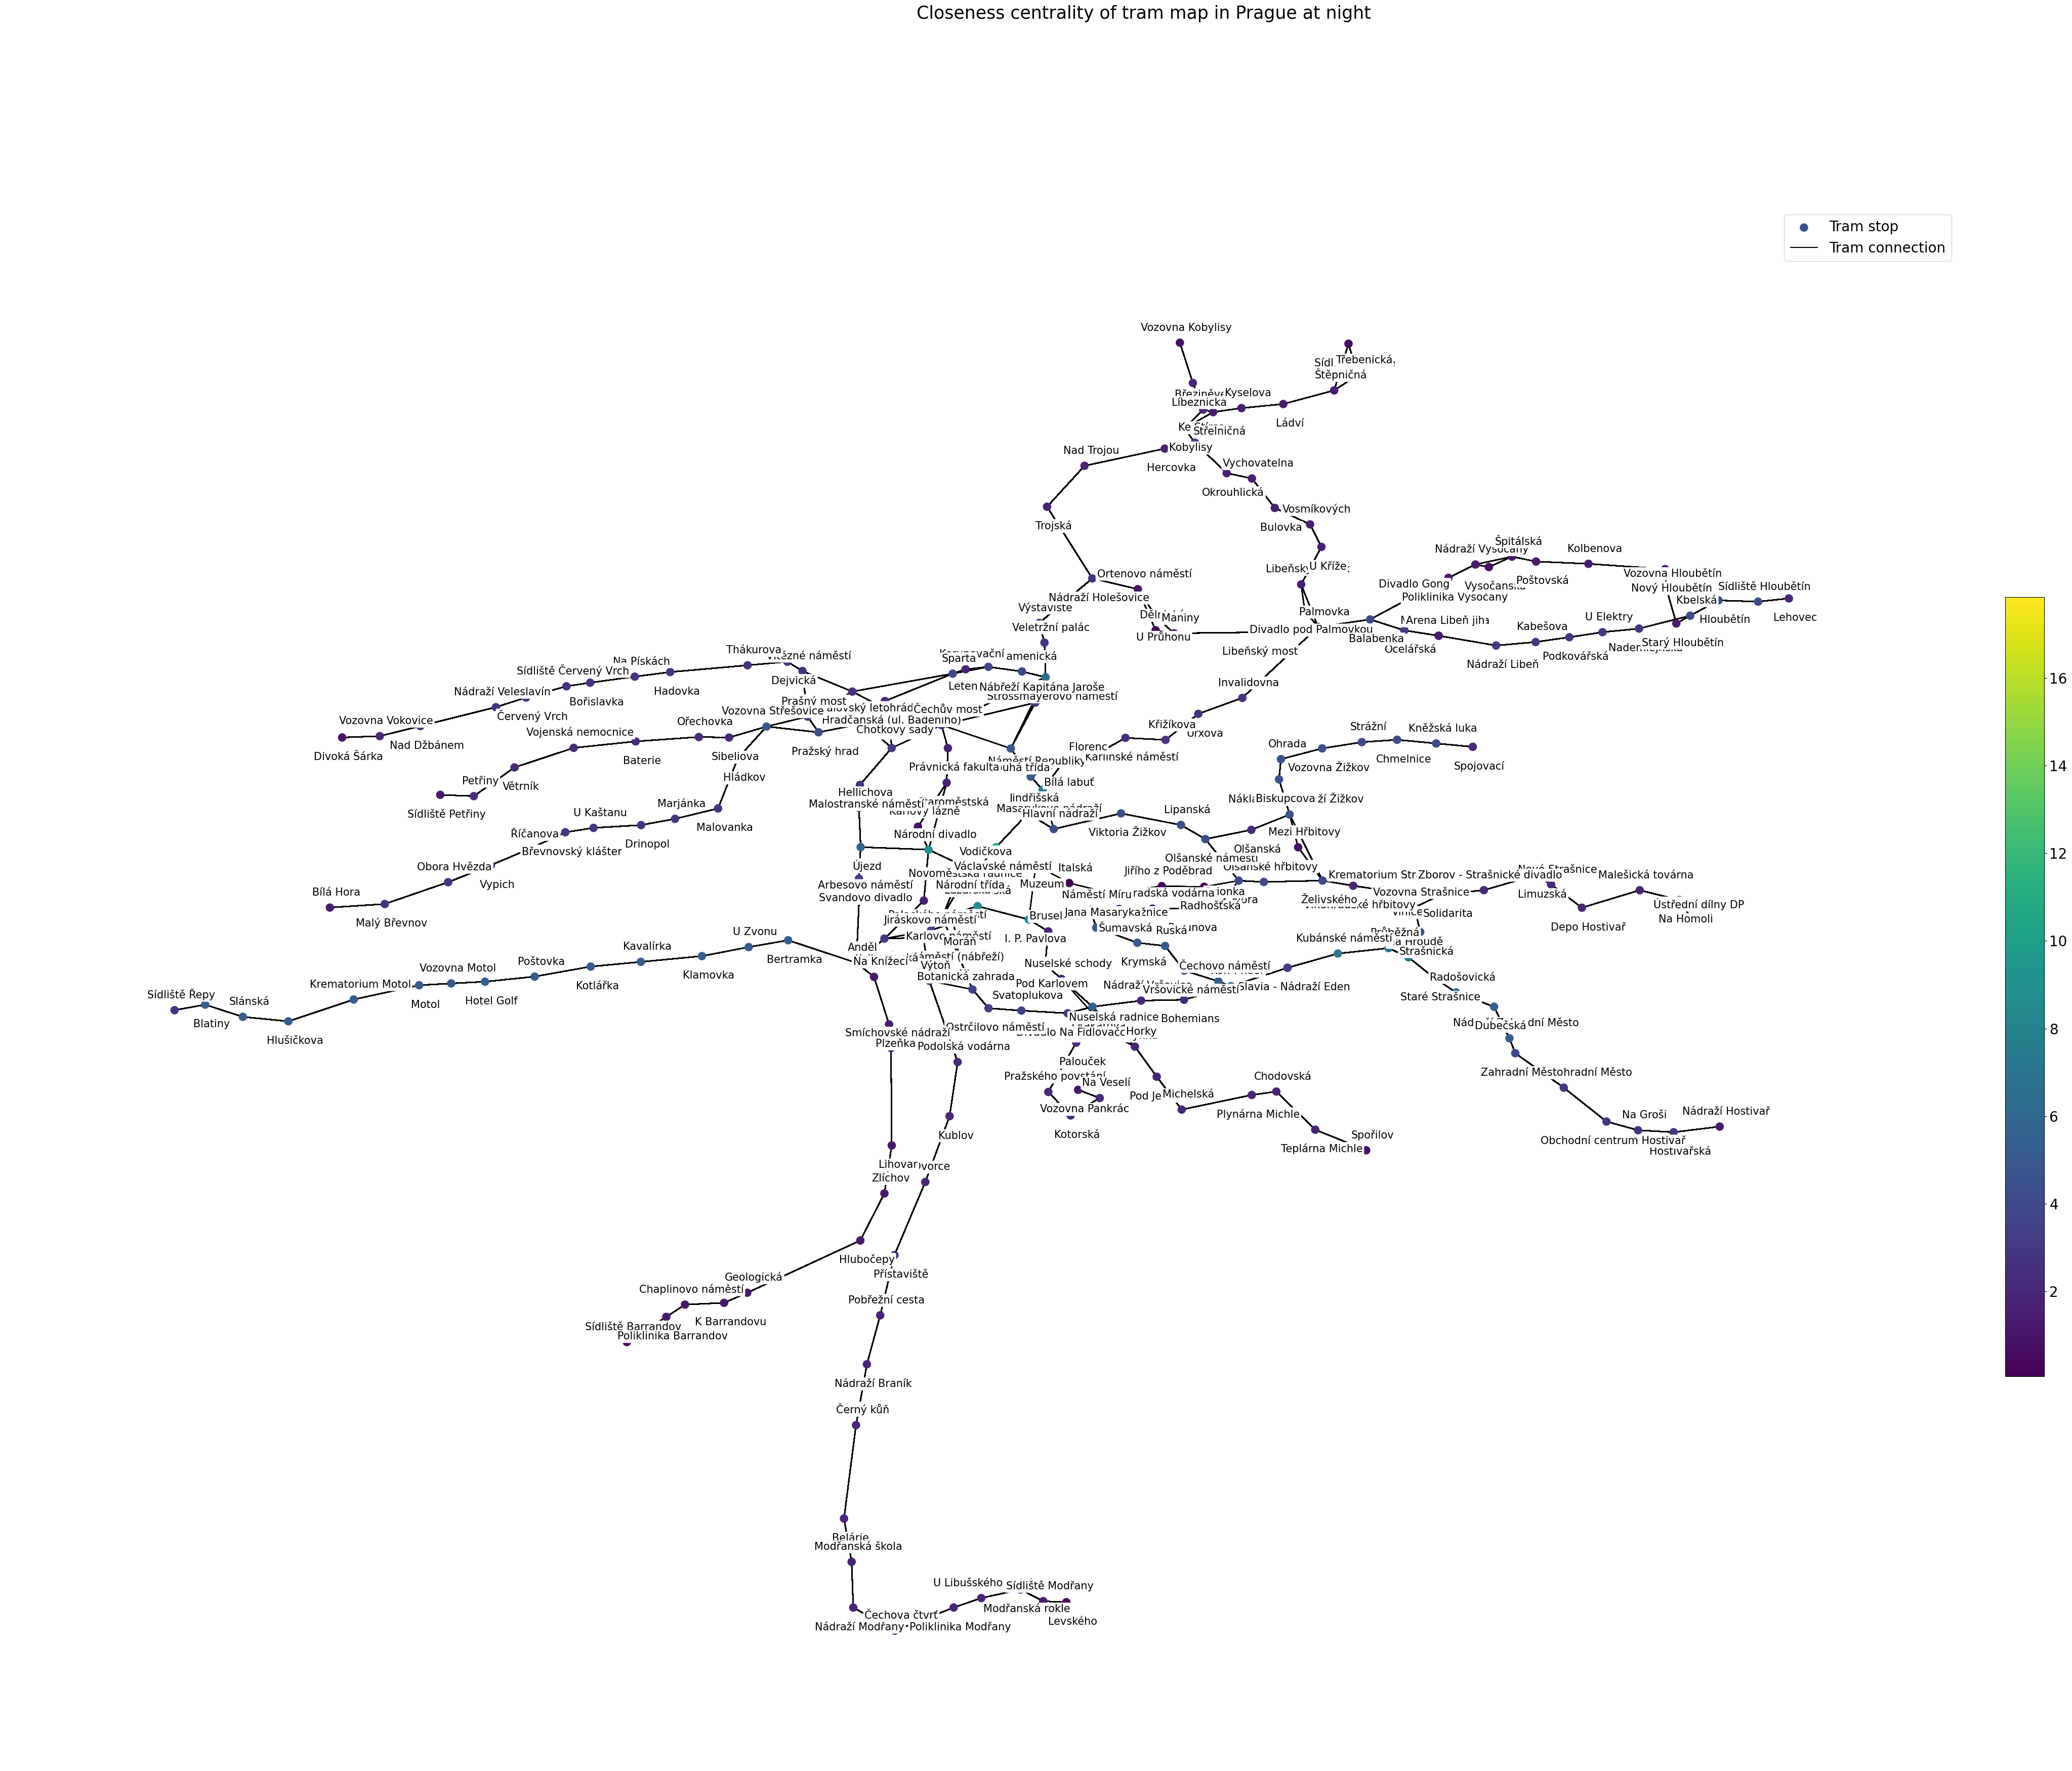

In [26]:
fig, ax = plt.subplots(figsize=(60, 40))

node_colors = [closeness_centrality[node] for node in tram_net_night_multi.nodes]

# drawing nodes
nx.draw_networkx_nodes(
    tram_net_night_multi,
    tram_stop_pos,
    node_color=node_colors,
    # setting up color map
    cmap=plt.cm.viridis,
    label = "Tram stop",
    node_size = 120,
)

# drawing edges
nx.draw_networkx_edges(
    tram_net_night_multi,
    tram_stop_pos,
    width = 1.5,
    style="solid",
    label="Tram connection",
    arrows=False
)

# names of stops
nx.draw_networkx_labels(
    tram_net_night_multi,
    tram_stop_names_pos,
    font_size = 15,
    horizontalalignment = "center",
    verticalalignment = "bottom",
    bbox=dict(boxstyle="round,pad=0.1", edgecolor="white", facecolor="white")
)

# adding color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
cbar = plt.colorbar(sm, orientation='vertical', shrink=0.5, pad=0.02, ax=ax)
cbar.ax.tick_params(labelsize=20)

plt.legend(fontsize='20')

fig.suptitle("Closeness centrality of tram map in Prague at night", size=25)
plt.axis("off")

plt.show()

2. Which bus stop has the highest degree centrality in bus network? Visualise top 10 bus stops with the highest degree centrality.

In [27]:
# filter bust records (3 - bus route)
df_bus = df_full[df_full['route_type'] == 3]

In [28]:
bus_net_multi = nx.MultiDiGraph()
for _, row in df_bus.iterrows():
    row_list = row.to_list()
    days_of_weeks = row_list[-7:]

    bus_net_multi.add_node(row['stop_from_name'])
    bus_net_multi.add_node(row['stop_to_name'])

    # adding edge for every day, which is True in dataset
    for day in days_of_weeks:
        if day:
            bus_net_multi.add_edge(row['stop_from_name'], row['stop_to_name'])

In [29]:
print("Number of bus stops - ", len(bus_net_multi.nodes))
print("Number of edges in bus_net_multi - ", len(bus_net_multi.edges))

Number of bus stops -  6638
Number of edges in bus_net_multi -  3919707


In [30]:
degree_centrality = nx.degree_centrality(bus_net_multi)
# sort trams stops by its degree centrality
degree_centrality_sorted = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
# top 10 for visualisation
top_ten = degree_centrality_sorted[0:10]

In [31]:
nodes, centrality_values = zip(*top_ten)

'Nemocnice Krč' is the bus stop, which has the highest degree centrality.

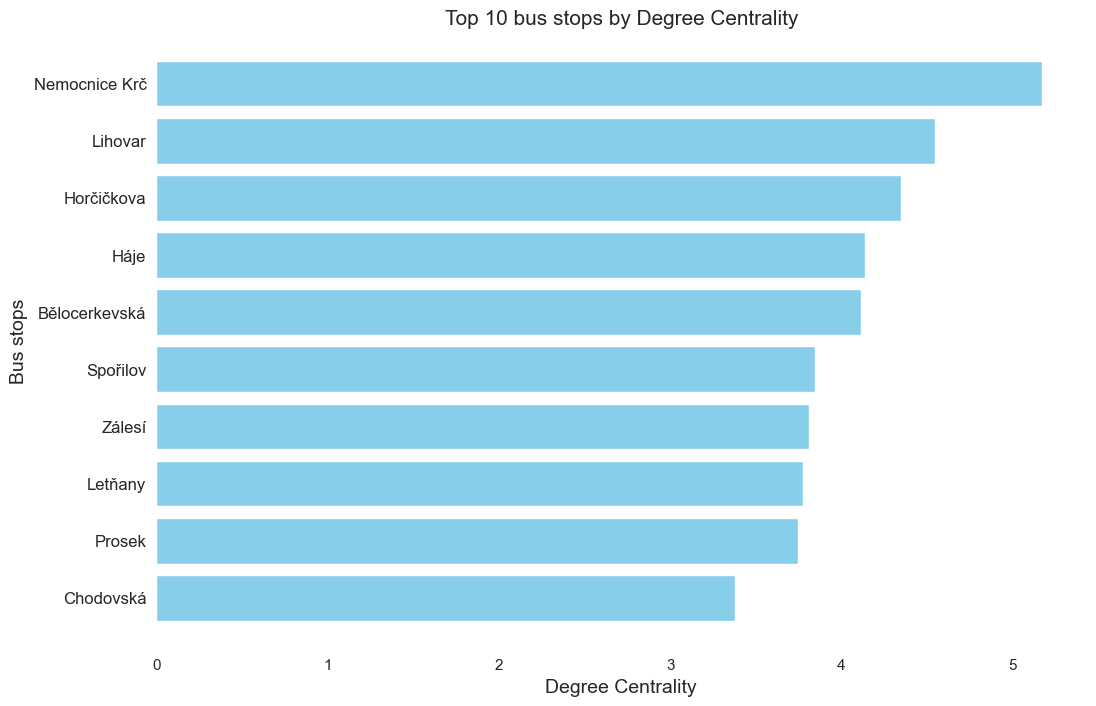

In [32]:
sns.set_style("white")

plt.figure(figsize=(12, 8))

plt.barh(nodes, centrality_values, color='skyblue')

plt.title("Top 10 bus stops by Degree Centrality", fontsize=15)

plt.yticks(fontsize=12)
plt.xticks(fontsize=11)

plt.xlabel("Degree Centrality", fontsize=14)
plt.ylabel("Bus stops", fontsize=14)

plt.gca().invert_yaxis()

# remove all spines
sns.despine(left=True, bottom=True, right=True, top=True)

plt.show()

3. What are important tram stops in terms of degree centrality during low load time between morning peak hours 7:00-9:00 and evening one, which starts at 17:00? Visualise centrality.


Because we have changed the types of features `depart_from` and `arrive_to` from object to datetime64 we can easily filter needed records. (Just to remind, datatime automatically fills in 1.1.1900 date, which we should use for our thresholds)

In [33]:
# from 9:00
down_threshold_datetime = datetime(1900, 1, 1, 9, 0, 0)
# to 17:00
up_threshold_datetime = datetime(1900, 1, 1, 17, 0, 0)

# filter tram records for specific time
df_tram_low_load = df_tram[(df_tram['depart_from'] >= down_threshold_datetime) & 
                           (df_tram['arrive_to'] <= up_threshold_datetime) & 
                           (df_tram['arrive_to'] >= down_threshold_datetime) & 
                           (df_tram['depart_from'] <= up_threshold_datetime)]

In [34]:
tram_net_low_multi = nx.MultiDiGraph()
for _, row in df_tram_low_load.iterrows():
    row_list = row.to_list()
    days_of_weeks = row_list[-7:]
    
    tram_net_low_multi.add_node(row['stop_from_name'])
    tram_net_low_multi.add_node(row['stop_to_name'])

    # adding edge for every day, which is True in dataset
    for day in days_of_weeks:
        if day:
            tram_net_low_multi.add_edge(row['stop_from_name'], row['stop_to_name'])

In [35]:
print("Number of nodes in tram_net_low_multi - ", len(tram_net_low_multi.nodes))
print("Number of edges in tram_net_low_multi - ", len(tram_net_low_multi.edges))

Number of nodes in tram_net_low_multi -  281
Number of edges in tram_net_low_multi -  1018374


In [36]:
degree_centrality = nx.degree_centrality(tram_net_low_multi)
degree_centrality_sorted = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
degree_centrality_sorted[0:10]

[('Karlovo náměstí', 87.125),
 ('Anděl', 79.40714285714286),
 ('Národní divadlo', 76.54642857142856),
 ('Strossmayerovo náměstí', 70.43928571428572),
 ('I. P. Pavlova', 67.12857142857143),
 ('Malostranská', 65.64642857142857),
 ('Národní třída', 65.5),
 ('Újezd', 61.97857142857143),
 ('Nákladové nádraží Žižkov', 60.43214285714286),
 ('Koh-i-noor', 57.52142857142857)]

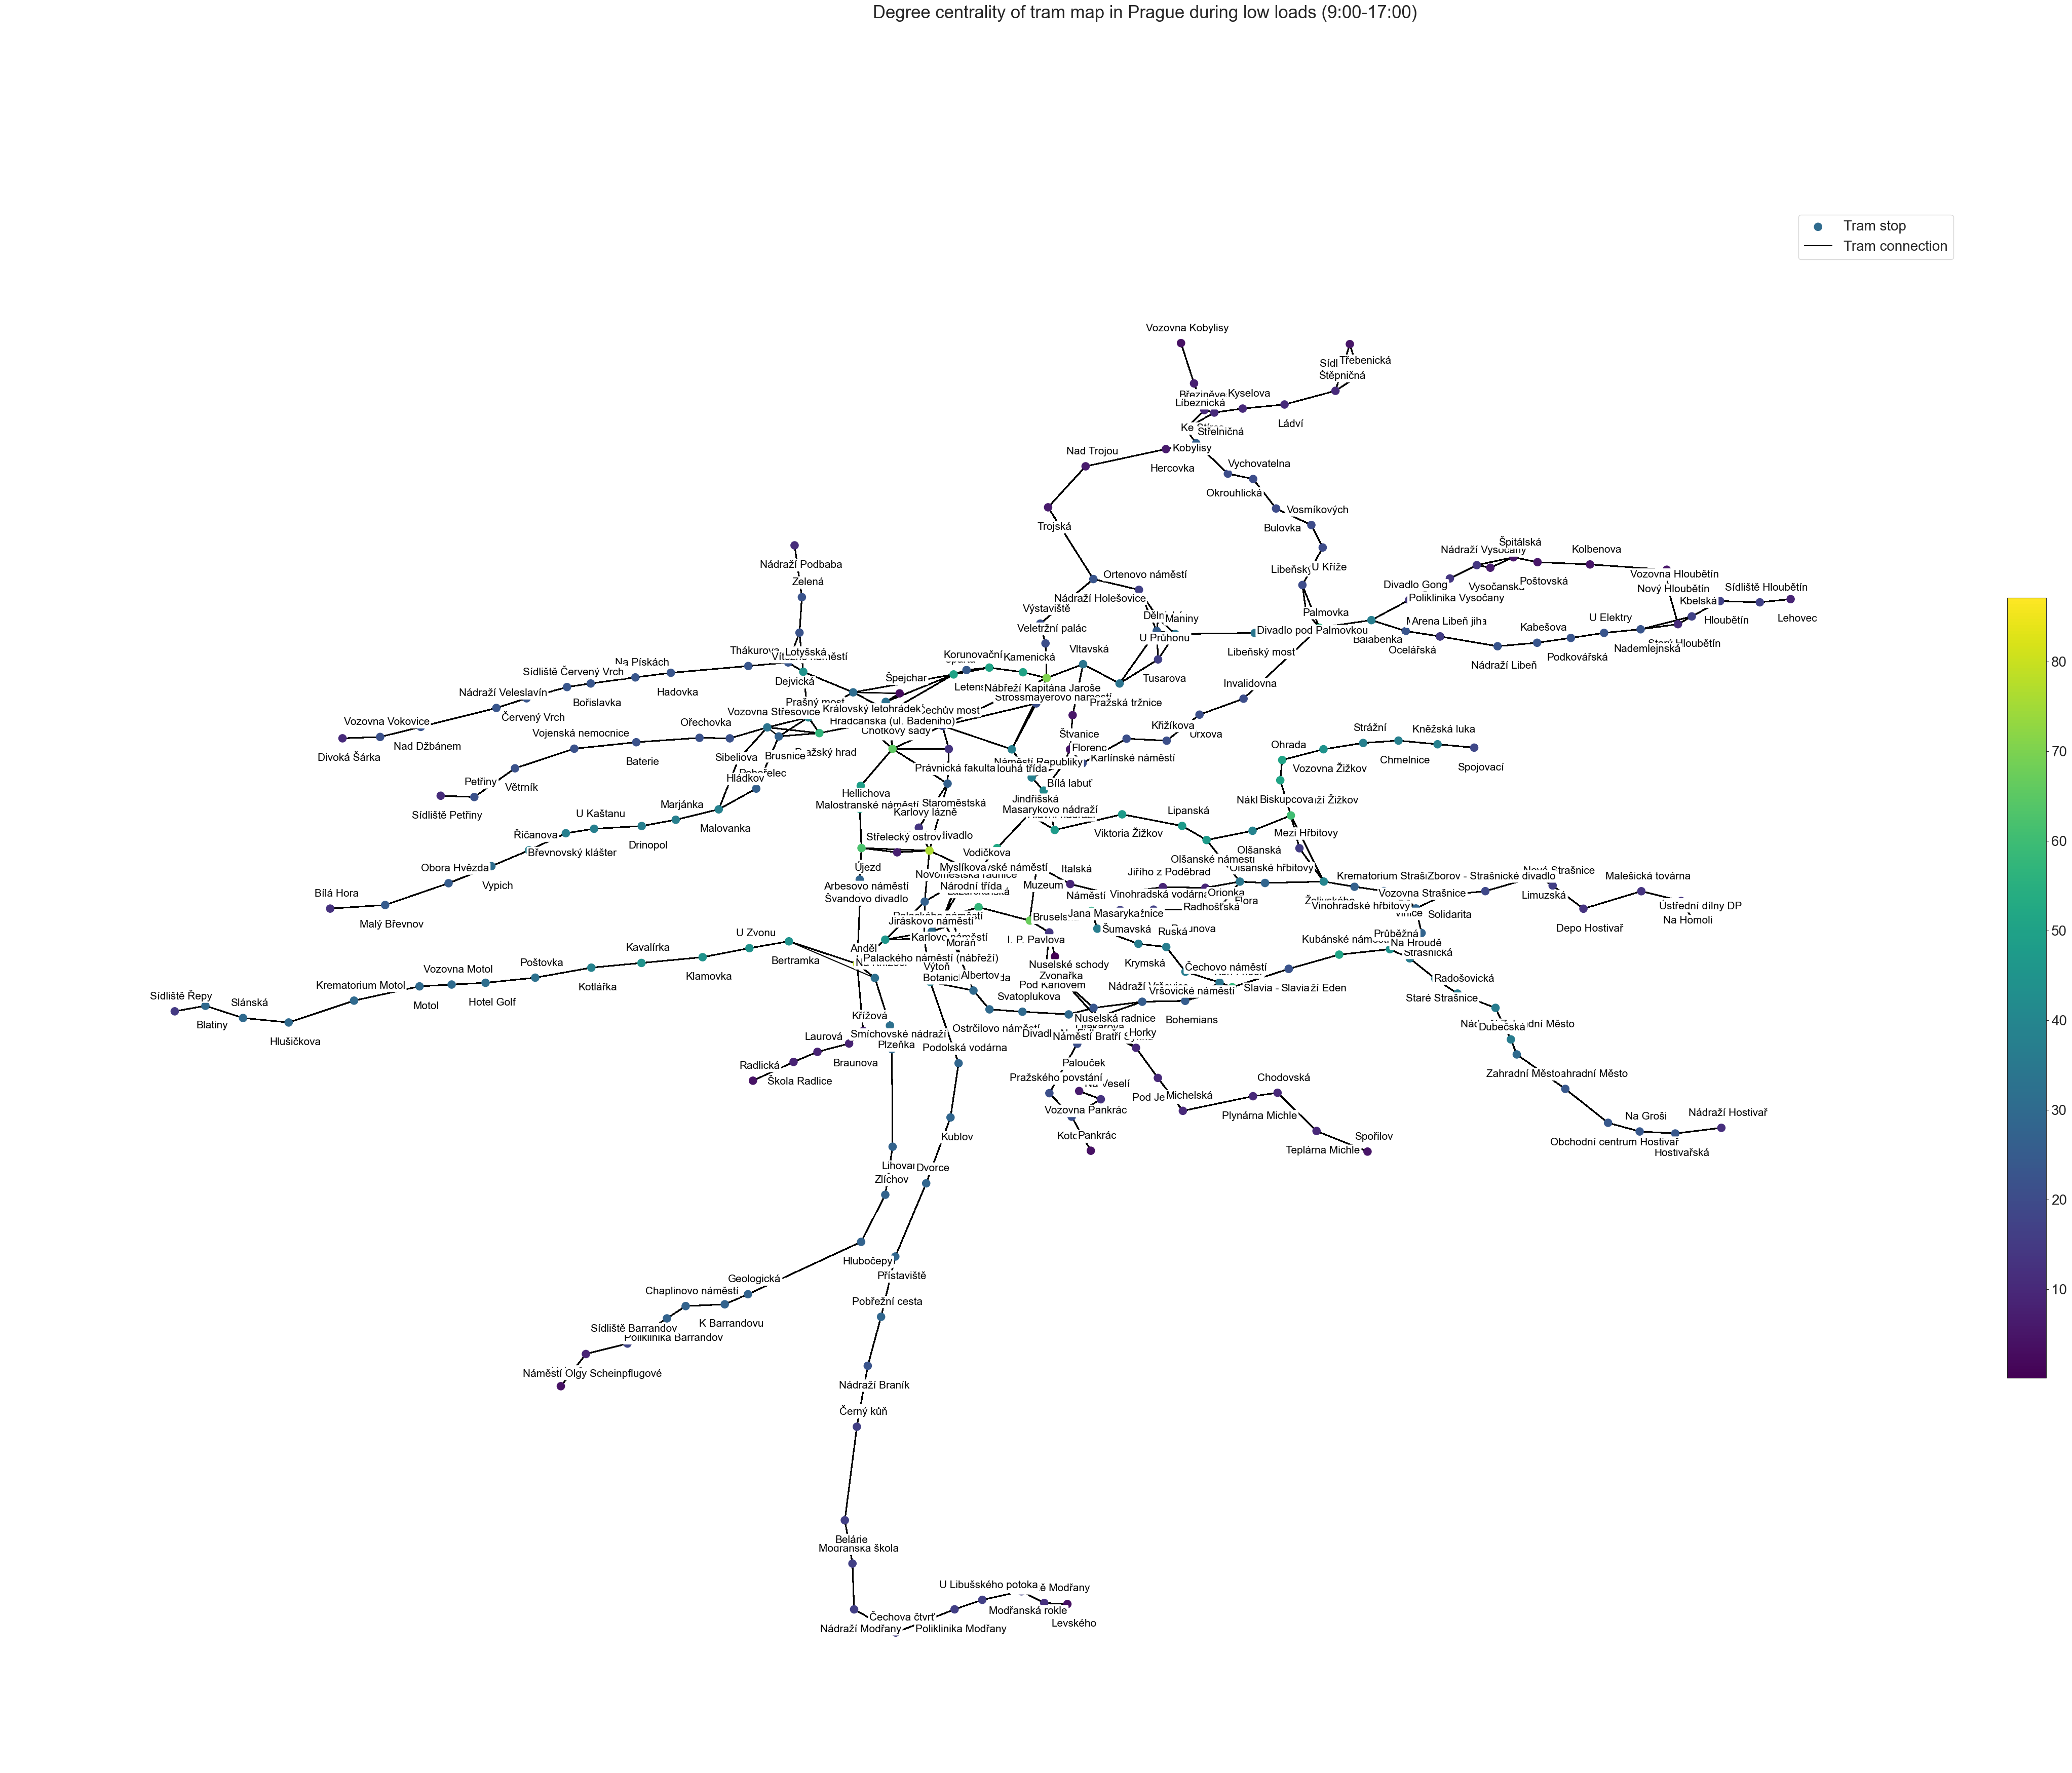

In [37]:
fig, ax = plt.subplots(figsize=(60, 40))

node_colors = [degree_centrality[node] for node in tram_net_low_multi.nodes]

# drawing nodes
nx.draw_networkx_nodes(
    tram_net_low_multi,
    tram_stop_pos,
    node_color=node_colors,
    # setting up color map
    cmap=plt.cm.viridis,
    label = "Tram stop",
    node_size = 120,
)

# drawing edges
nx.draw_networkx_edges(
    tram_net_low_multi,
    tram_stop_pos,
    width = 1.5,
    style="solid",
    label="Tram connection",
    arrows=False
)

# names of stops
nx.draw_networkx_labels(
    tram_net_low_multi,
    tram_stop_names_pos,
    font_size = 15,
    horizontalalignment = "center",
    verticalalignment = "bottom",
    bbox=dict(boxstyle="round,pad=0.1", edgecolor="white", facecolor="white")
)

# adding color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
cbar = plt.colorbar(sm, orientation='vertical', shrink=0.5, pad=0.02, ax=ax)
cbar.ax.tick_params(labelsize=20)

plt.legend(fontsize='20')

fig.suptitle("Degree centrality of tram map in Prague during low loads (9:00-17:00)", size=25)
plt.axis("off")

plt.show()